In [1]:
#%load_ext autoreload
#%autoreload 2

import os

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm

import pickle as pkl
import seaborn as sbn

import time

import torch

import sys 
sys.path.append('./python/')
from HillModel import * 
from LogisticModel import *
from DrugCombinationGP import *

%matplotlib notebook

# Combination Index Analysis 

[CI Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2885905/pdf/nihms200765.pdf).   

1. Zhao L, Au JL-S, Wientjes MG. Comparison of methods for evaluating drug-drug interaction. Front Biosci (Elite Ed). 2010 Jan 1;2:241–9.   


Analysis Overview:   

0. Load Data (data pre-processing documented [here](https://github.com/nathanieljevans/HNSCC_functional_data_pipeline))
    - see `python/process_data.py` for more info.     
1. Fit Drug A regression and calcuate ICxx (user defined). Recommend to use value between 50-75.   
2. Fit Drug B (trametinib) regression and caclcuate ICxx   
3. Fit Combination regression (matrix format of concentration values)   
4. Calculate CI values and plot isobologram   
5. Calculate minimum CI values and regions of synergy.   

## Isobologram 

<img src="https://www.mdpi.com/toxics/toxics-03-00342/article_deploy/html/images/toxics-03-00342-g001-1024.png" width="400" height="400"/>


## CI calculated as ... 

$$ CI = \frac{C_{xx}^{A}}{IC_{xx}^{A}} + \frac{C_{xx}^{B}}{IC_{xx}^{B}} $$  

Where $C_{xx}^{A}$, $C_{xx}^{A}$ are the concentrations of A, B respectively in combination when inhibition is xx%.   


## Sensitive/Resistant Lines 

Trametinib sensitive lab_id's: 10004, 10292  
Trametinib resistant lab_id's: 20003, 10326, 10336   

# Tutorial Config

In [2]:
lab_id = 10004

drugA = 'HESPERIDIN'
drugB = 'TRAMETINIB'

IC_value = 0.5

# Load Data

In [3]:
trem13 = pd.read_csv('./data/Trametinib_Data.csv')
trem13 = trem13.assign(inhibitor='TRAMETINIB', conc=trem13['Conc(uM)'], lab_id=trem13['Cell_Line'], cell_viab=trem13['Cell_Viability'])
trem13 = trem13[['lab_id', 'inhibitor', 'conc', 'cell_viab']].assign(dataset='trem-single13')

combo_data = pd.read_csv('./data/all_trem_combo_data.csv').dropna().drop('Unnamed: 0', axis=1).assign(dataset = 'trem-combo')

data_all = pd.concat([combo_data, trem13], axis=0)
data_all.head()

,lab_id,inhibitor,conc,cell_viab,dataset
17,10004,HESPERIDIN,1,1.0,trem-combo
18,10004,HESPERIDIN,0.3333333333333333,1.0,trem-combo
19,10004,HESPERIDIN,0.1111111111111111,1.0,trem-combo
20,10004,HESPERIDIN,0.03703703703703703,1.0,trem-combo
21,10004,HESPERIDIN,0.01234567901234568,1.0,trem-combo


In [4]:
data_all.lab_id.unique()

array([10004, 10292, 10326, 10336, 20003, 10250])

In [5]:
# filter to lab_id 
data_all = data_all[lambda x: x.lab_id == lab_id]

# Examine Avaliable Inihibitors 

These should be (after renaming) all be capitolized. If they are not, that drug will need to be added to the `drug_rework.xlsx` page. 

In [6]:
single_agents = data_all[~data_all.inhibitor.str.contains(';')].inhibitor.unique()
comb_agents = data_all[data_all.inhibitor.str.contains(';')].inhibitor.unique()

print('number of inhibitors:', len(single_agents) + len(comb_agents))
print('number of single agents:', len(single_agents))
print('number of combination agents:', len(comb_agents))
print()
print('\n'.join(single_agents))
print()
print('\n'.join(comb_agents))

number of inhibitors: 49
number of single agents: 26
number of combination agents: 23

HESPERIDIN
NONE
AZD4547
TRAMETINIB
NVP-ADW742
GSK-690693
CRIZOTINIB
GEFITINIB
F-S-V
FULVESTRANT
MLN120B
IXABEPOLONE
I-BET762
NILOTINIB
GLESATINIB
BGB324
AXITINIB
SGX-523
GILTERITINIB
GDC-0032
RUXOLITINIB PHOSPHATE
AZ960
FEDRATINIB
LAPATINIB DITOSYLATE
THALIDOMIDE
STEVIOSIDE

HESPERIDIN;TRAMETINIB
AZD4547;TRAMETINIB
NVP-ADW742;TRAMETINIB
GSK-690693;TRAMETINIB
CRIZOTINIB;TRAMETINIB
GEFITINIB;TRAMETINIB
FULVESTRANT;TRAMETINIB
MLN120B;TRAMETINIB
IXABEPOLONE;TRAMETINIB
I-BET762;TRAMETINIB
NILOTINIB;TRAMETINIB
GLESATINIB;TRAMETINIB
BGB324;TRAMETINIB
AXITINIB;TRAMETINIB
SGX-523;TRAMETINIB
GILTERITINIB;TRAMETINIB
GDC-0032;TRAMETINIB
RUXOLITINIB;TRAMETINIB
AZ960;TRAMETINIB
FEDRATINIB;TRAMETINIB
LAPATINIB;TRAMETINIB
THALIDOMIDE;TRAMETINIB
STEVIOSIDE;TRAMETINIB


# Choose Drug Combo

In [7]:
dataA = data_all[data_all.inhibitor == drugA]
dataB = data_all[data_all.inhibitor == drugB]
dataAB = data_all[data_all.inhibitor == ';'.join([drugA, drugB])]

print('dataframe shapes')
print('\tA:', dataA.shape)
print('\tB:', dataB.shape)
print('\tAB:',dataAB.shape)

print('\ndataB # doses: ', dataB.conc.unique())

dataframe shapes
	A: (6, 5)
	B: (222, 5)
	AB: (36, 5)

dataB # doses:  ['0.0001234567901234568' '0.0003703703703703704' '0.001111111111111111'
 '0.003333333333333334' '0.01' '0.03' 10.41 3.123 1.041 0.3123 0.1041
 0.03123 0.01041 0.003123 0.001041 0.0003123 0.0001041 3.12e-05 1.04e-05]


# Fit Regressions 

This will be used to calculate the ICxx values necessary for the CI. 

## Drug A 

Emax init [0.38524902]
E0 init 1
H init [0.9266428]


<IPython.core.display.Javascript object>


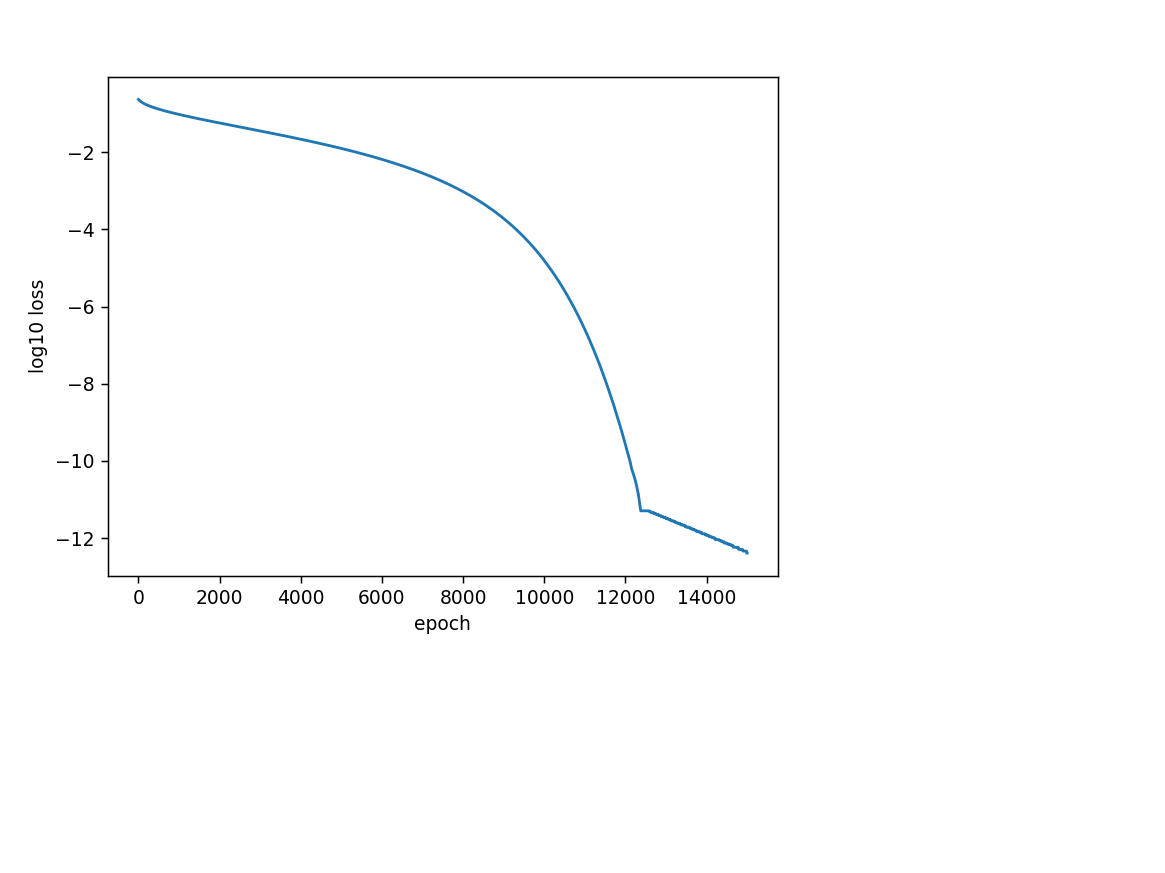

<IPython.core.display.Javascript object>


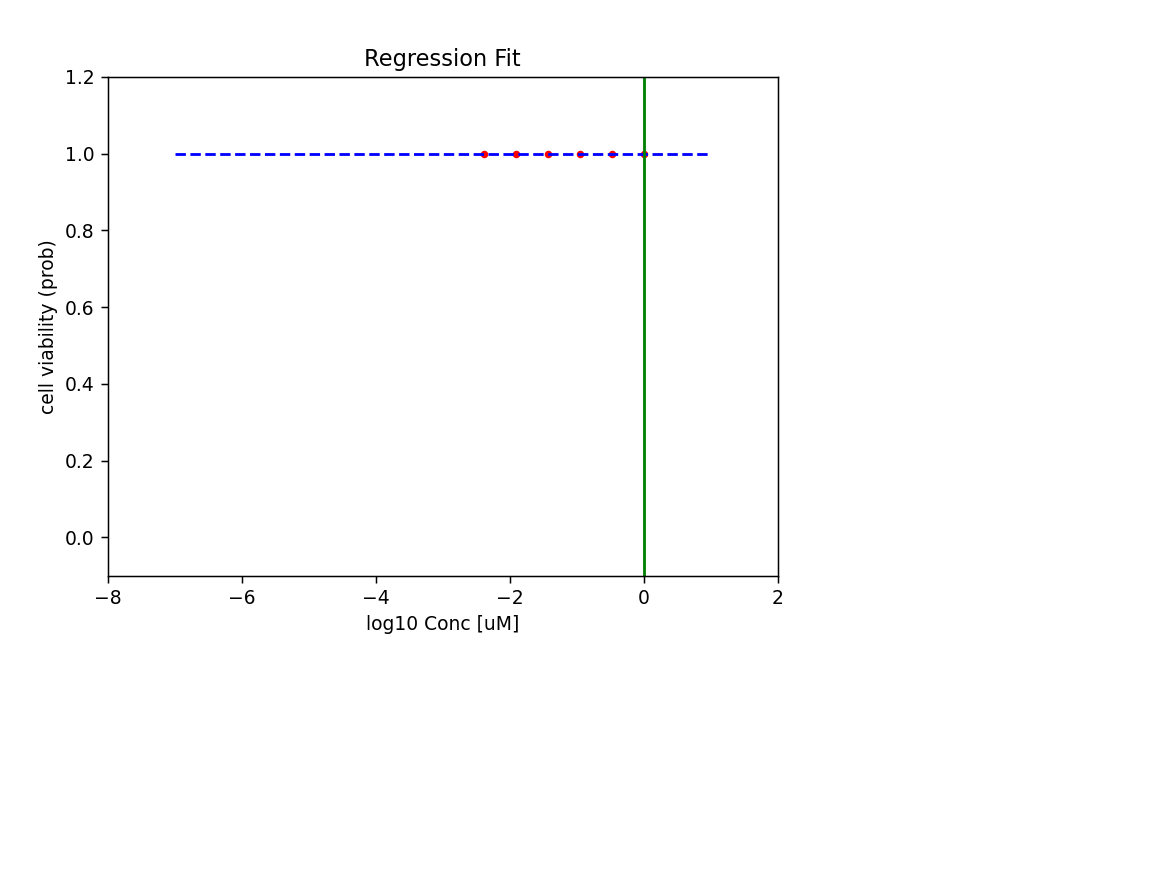

plot fit, (um) ICxx = 1.0
| PARAMETER | VALUE |
|-----------|-------|
|  Emax     |1.00000|
|  E0       |1.00000|
|  EC50     |0.21400|
|  H        |0.58627|
equality IC A: greater_than
IC0.5: 1.0
IC0.5: 0.0 log10(uM)


In [8]:
xA = np.log10(dataA.conc.values.astype(np.float))
yA = dataA.cell_viab.values 

# Hill Regression
modelA = HillModel()
modelA.fit(10**xA, yA, epochs=15000, learningRate=1e-4)
modelA.plot_fit(ICxx = IC_value*100)
modelA.summary()

ICxxA, eqA = modelA.get_IC(IC_value)

print('equality IC A:', eqA)
print(f'IC{IC_value}: {ICxxA}')
print(f'IC{IC_value}: {np.log10(ICxxA)} log10(uM)')
# Hill Model returns ICxx in uM, Logistic returns it in logspace
ICxxA = np.log10(ICxxA)

## Drug B: Trametinib 

### Are the two datasets are concordant?

<IPython.core.display.Javascript object>


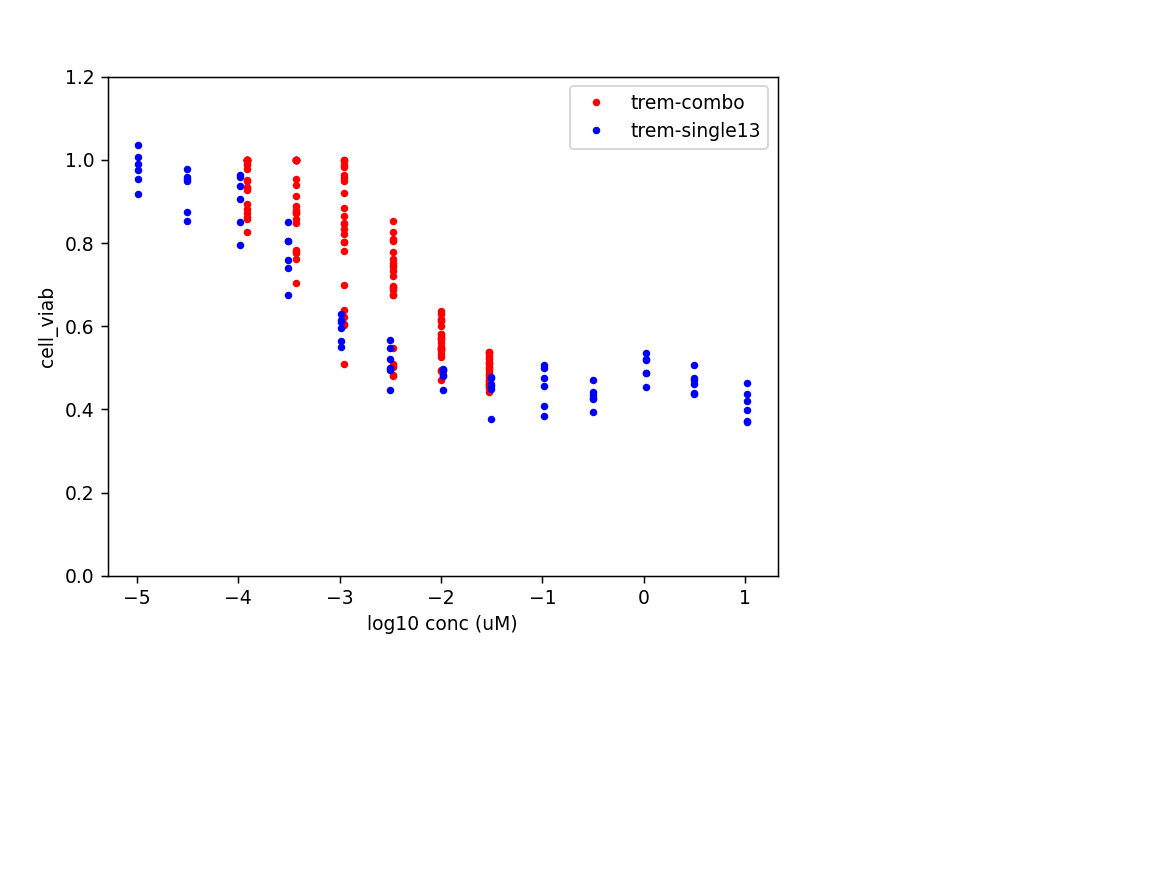

In [9]:
plt.figure()
plt.plot(np.log10( dataB[dataB.dataset=='trem-combo'].conc.astype(np.float) ), dataB[dataB.dataset=='trem-combo'].cell_viab.astype(np.float), 'r.', label='trem-combo')
plt.plot(np.log10( dataB[dataB.dataset=='trem-single13'].conc.astype(np.float) ), dataB[dataB.dataset=='trem-single13'].cell_viab.astype(np.float), 'b.', label='trem-single13')
plt.xlabel('log10 conc (uM)')
plt.ylabel('cell_viab')
plt.legend()
plt.ylim(0, 1.2)
plt.show()

### Fit Trametinib 

Use both datasets) 

Emax init [-0.54469734]
E0 init 1
H init [1.1421078]


<IPython.core.display.Javascript object>


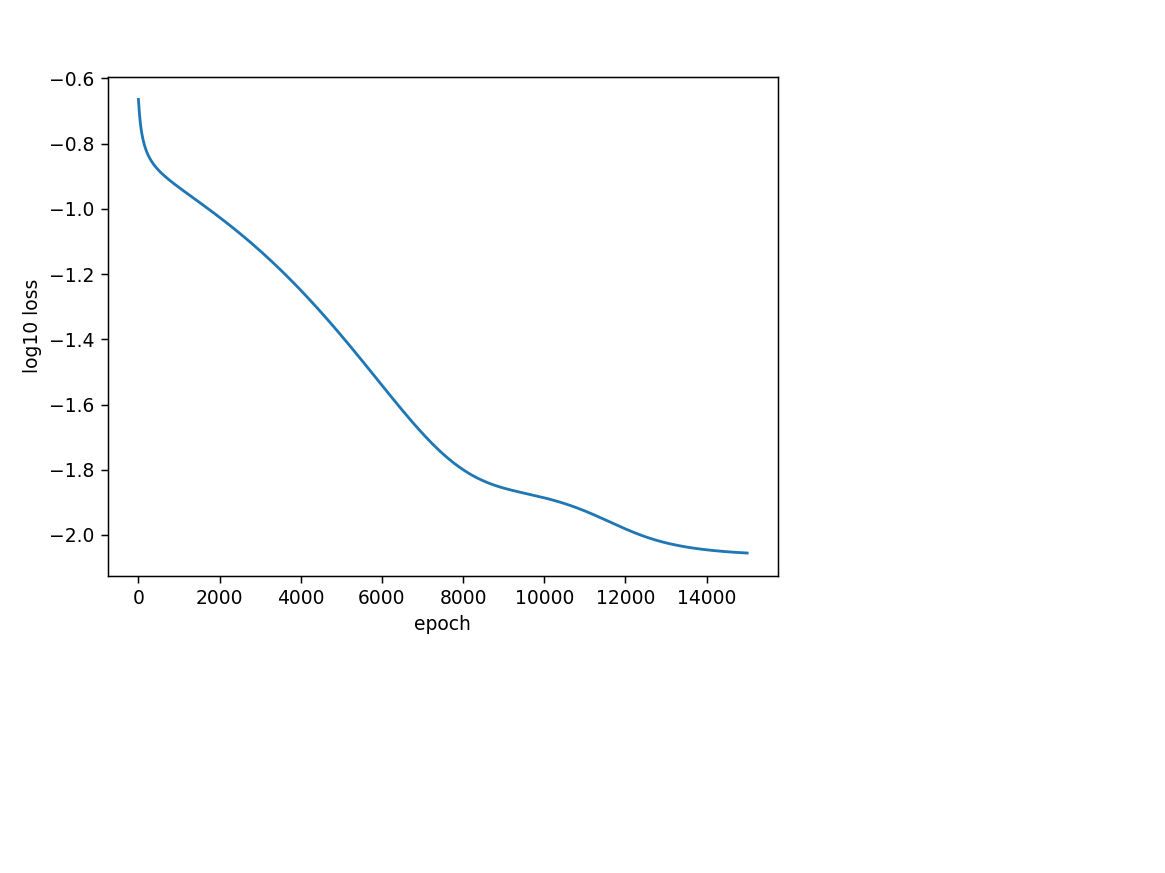

<IPython.core.display.Javascript object>


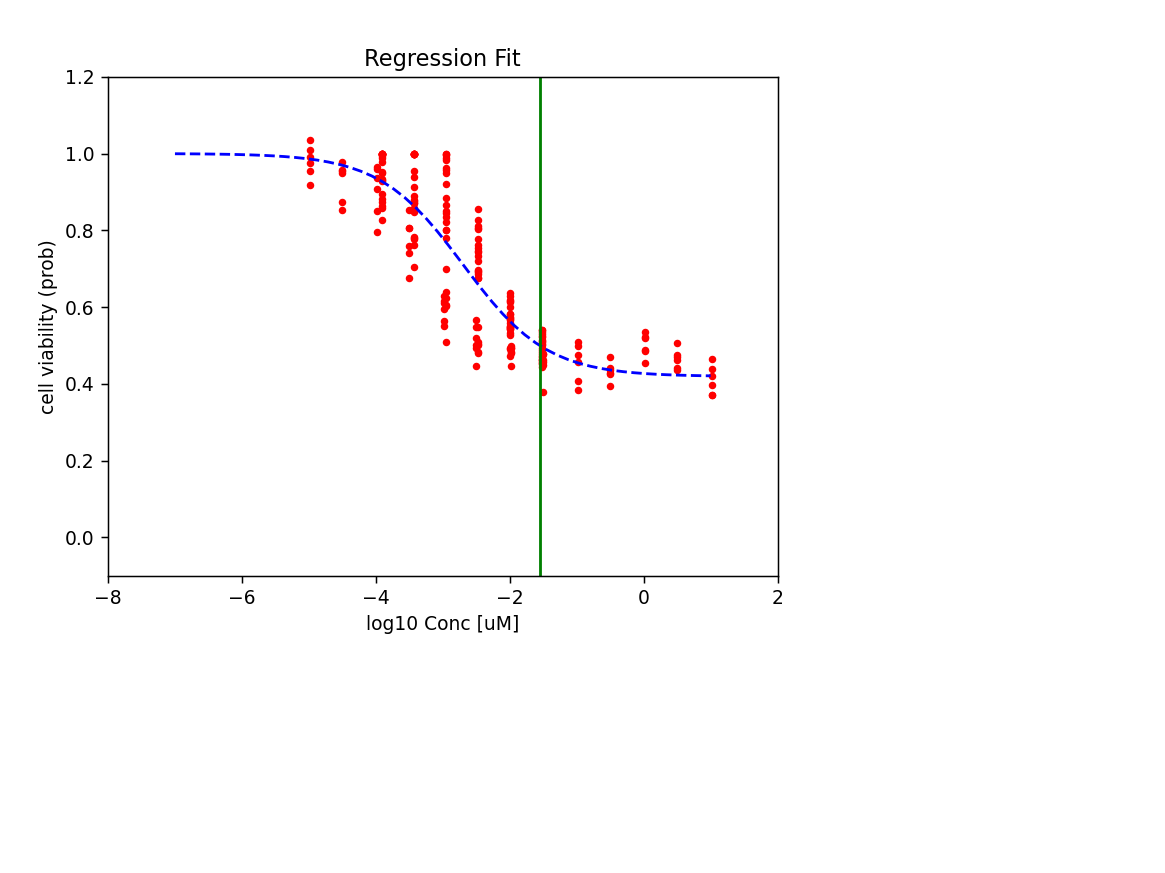

plot fit, (um) ICxx = 0.027871309718076442
| PARAMETER | VALUE |
|-----------|-------|
|  Emax     |0.41921|
|  E0       |1.00000|
|  EC50     |0.00203|
|  H        |0.69535|
equality IC B: equal_to
IC0.5: 0.027871309718076442 uM
IC0.5: -1.5548426226046455 log10(uM)


In [10]:
xB = np.log10(dataB.conc.values.astype(np.float))
yB = dataB.cell_viab.values

#ICxxB = fit_logistic(drugB, x, y, ICxx=IC_value, plot=True)

modelB = HillModel()
modelB.fit(10**xB, yB, epochs=15000, learningRate=1e-4)
modelB.plot_fit(ICxx = IC_value*100)
modelB.summary()
ICxxB, eqB = modelB.get_IC(IC_value*100)
print('equality IC B:', eqB)
print(f'IC{IC_value}: {ICxxB} uM')
print(f'IC{IC_value}: {np.log10(ICxxB)} log10(uM)')

# Hill Model returns ICxx in uM, Logistic returns it in logspace
ICxxB = np.log10(ICxxB)

# Combination Agent 

In [11]:
x = dataAB.conc.values
Z = dataAB.cell_viab.values

A=[]; B=[]
for xx in x: 
    A.append( float(xx.split(';')[0]) )
    B.append( float(xx.split(';')[1]) )
    
A = np.log10( np.array(A) )
B = np.log10( np.array(B) )

#print(A,B)

In [12]:
endog = dataAB.cell_viab.values
exog = sm.add_constant( np.concatenate((A.reshape(-1,1),B.reshape(-1,1)), axis=1) )

<IPython.core.display.Javascript object>


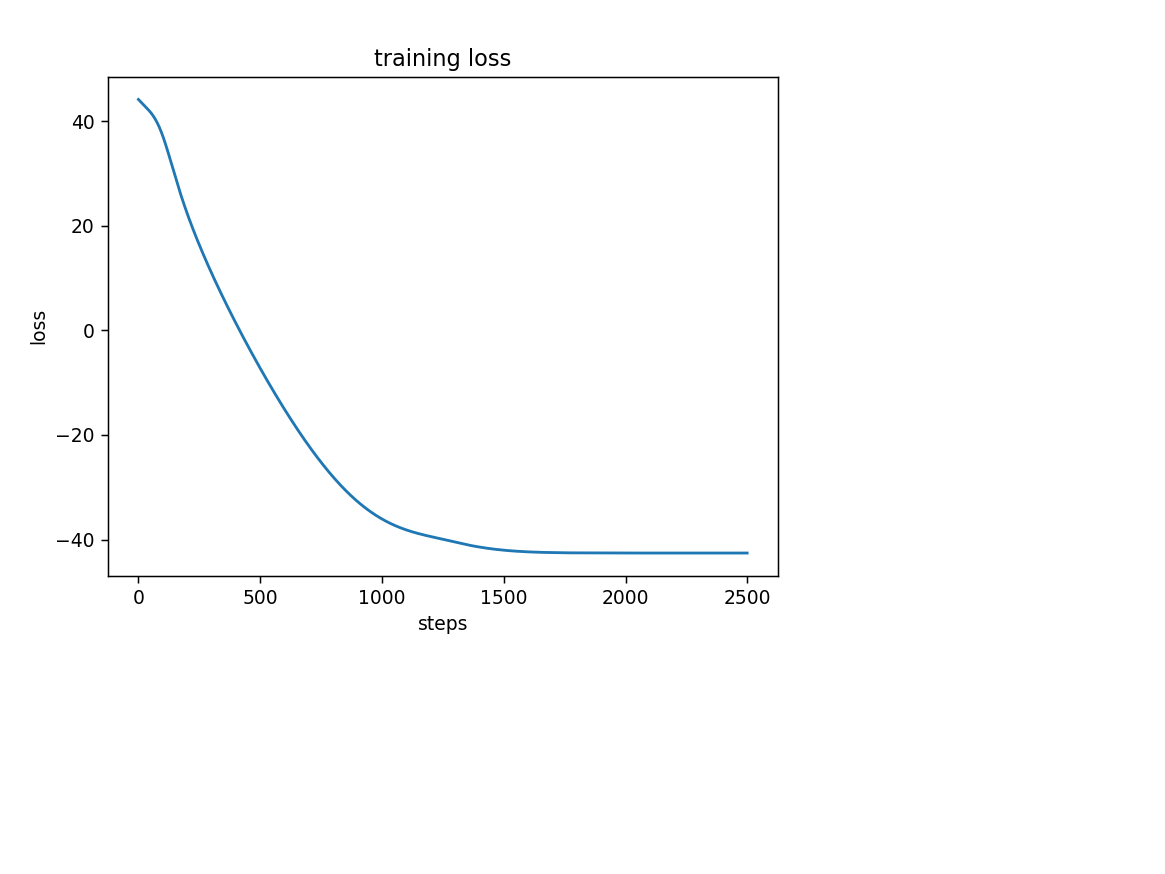

# of IC values found: 48


<IPython.core.display.Javascript object>


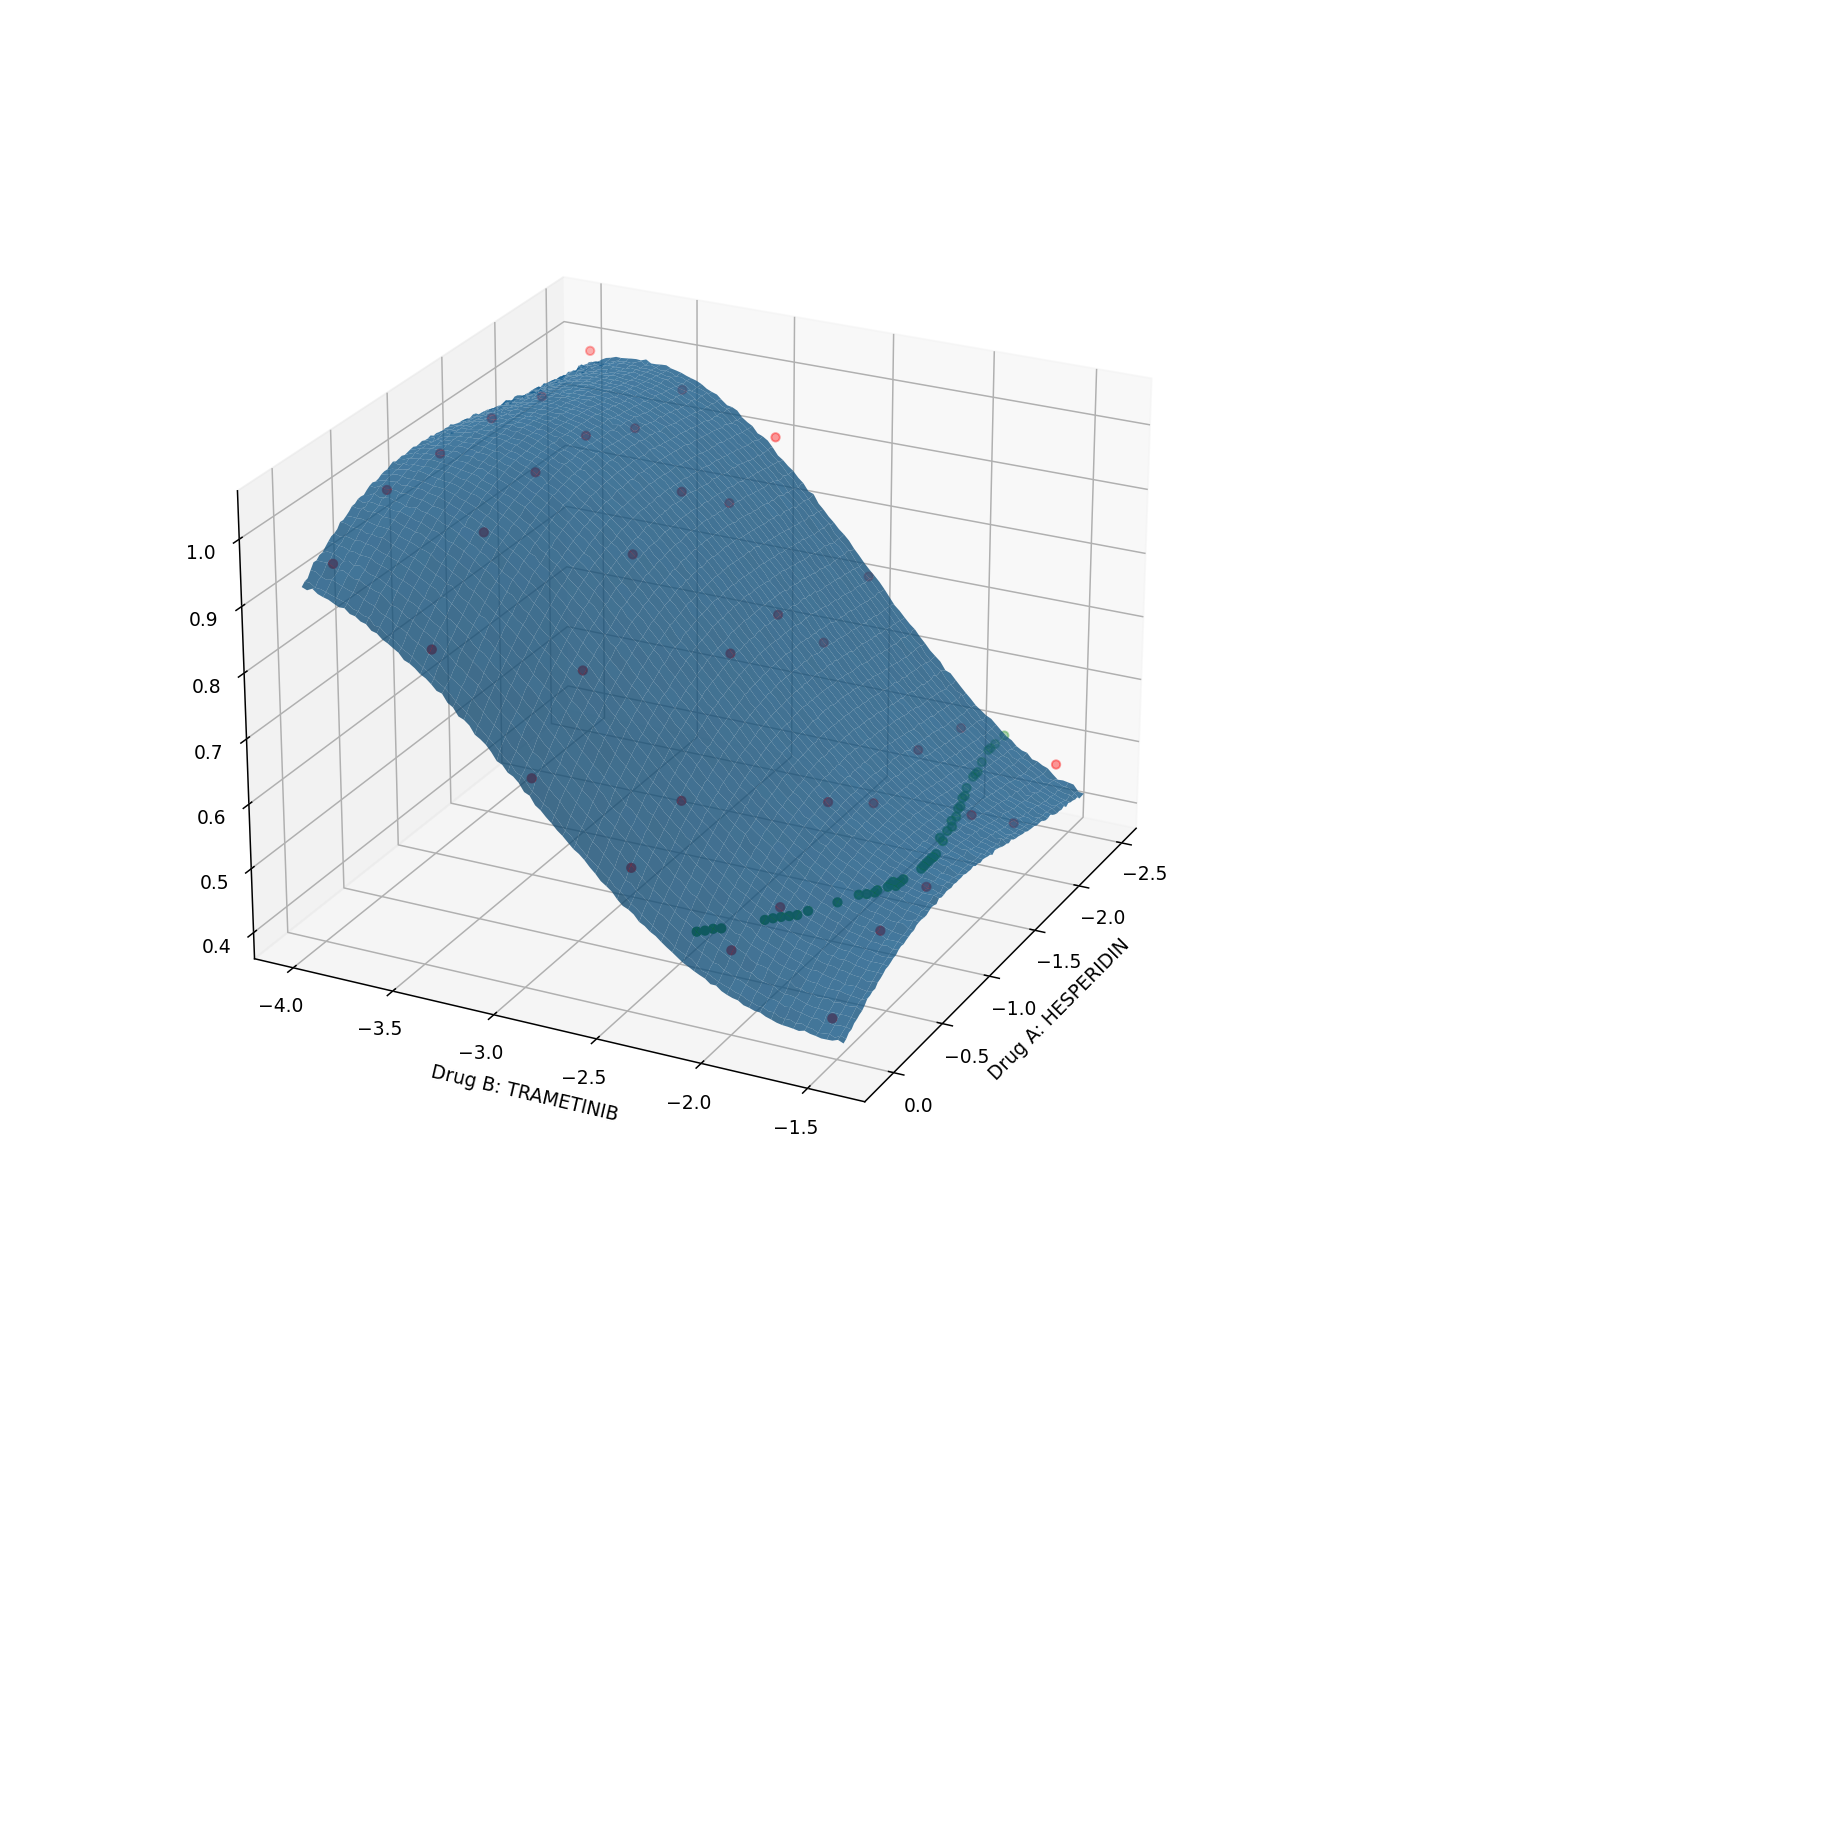

In [13]:
######################################################################################
######################################################################################
num_meshgrid_samples = 100
margin = 0.1
allowed_ic_delta = 0.001
nsamples = 300
lr = 0.005
nsteps = 2500
######################################################################################
######################################################################################

concs = [x.split(';') for x in dataAB.conc.values] 
concs = np.array(concs)

x_ab = torch.FloatTensor(np.log10(concs.astype(np.float)))
y_ab = torch.FloatTensor(dataAB.cell_viab.values.astype(np.float))

ComboAB_GP = DrugCombinationGP()
ComboAB_GP.fit(x_ab, y_ab, num_steps=nsteps, learning_rate=lr)

#axGP = ComboAB_GP.plot_results(X_range=(x_ab.detach().numpy().min()-1, x_ab.detach().numpy().max()+1, 0.1))

log_concs = np.log10( concs.astype(np.float) )
concA_range = (log_concs[:,0].min()-margin, log_concs[:,0].max()+margin, num_meshgrid_samples)
concB_range = (log_concs[:,1].min()-margin, log_concs[:,1].max()+margin, num_meshgrid_samples)
Av, Bv = np.meshgrid(np.linspace(*concA_range), np.linspace(*concB_range))

Ax = Av.reshape((-1,))
Bx = Bv.reshape((-1,))
Xnew = torch.FloatTensor(np.concatenate((Ax.reshape(-1,1), Bx.reshape(-1,1)), 1))
comb_samples = np.array( ComboAB_GP.sample(Xnew, n=nsamples) )
GP_comb_mean = comb_samples.mean(axis=0).reshape(Av.shape)

idx_ic_comb = np.where((np.abs(GP_comb_mean - IC_value).min(axis=0)))
comb = pd.DataFrame({'x':Av[idx_ic_comb].reshape(-1),'y':Bv[idx_ic_comb].reshape(-1),'z':GP_comb_mean[idx_ic_comb].reshape(-1)})
comb = comb[lambda x: (x.z < IC_value + allowed_ic_delta) & (x.z > IC_value - allowed_ic_delta)]
print('# of IC values found:', len(comb))

xx = x_ab[:,0].detach().numpy()
yy = x_ab[:,1].detach().numpy()
zz = y_ab.detach().numpy()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Av, Bv, GP_comb_mean, alpha=0.8)
plt.xlabel(f'Drug A: {drugA}')
plt.ylabel(f'Drug B: {drugB}')
ax.scatter(xs=xx, ys=yy, zs=zz, c='r', label='obs')
ax.scatter(xs=comb['x'], ys=comb['y'], zs=comb['z'], c='g', label="ICxx's")
plt.show()

# use this to compare the logistic fit 
if False: 
    logit = sm.GLM(endog, exog, family=sm.families.Binomial()) 
    res = logit.fit(disp=False)

    X = np.arange(-3, 1, 0.01)
    Y = np.arange(-5, -1, 0.01)
    X, Y = np.meshgrid(X, Y)

    ICs = {'x':[], 'y':[], 'z':[]} 
    Zmat = [] 
    for xx, yy in zip(X, Y): 
        exog2 = sm.add_constant( np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1), has_constant='add') 
        yyhat = res.predict( exog2 )
        Zmat.append( yyhat )

        for xxx,yyy in zip(xx, yy): 
            yyyhat = res.predict( np.array([1,xxx,yyy]) )[0]
            if np.isclose(yyyhat, IC_value, atol=0.001, rtol=0): 
                ICs['x'].append(xxx)
                ICs['y'].append(yyy)
                ICs['z'].append(yyyhat)


    Zmat = np.array( Zmat ) 
    print ('Z shape:', Z.shape)
    
    # Plot the surface.
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(A,B,Z, c='r')
    ax.plot_surface(X, Y, Zmat, alpha=0.7, cmap='RdYlGn')
    ax.scatter(ICs['x'], ICs['y'], ICs['z'], c='g')
    ax.set_xlabel(f'X axis: {drugA}')
    plt.show()

# Calculate minimum CI values and plot isobologram

drugA (HESPERIDIN) IC0.5: 1.0 (uM) [log=0.0]
drugB (TRAMETINIB) IC0.5: 0.027871309718076442 (uM) [log=-1.5548426226046455]
             x         y         z
7094 -0.030586 -2.180279  0.500162
7193 -0.056703 -2.154161  0.499919
7292 -0.082821 -2.128044  0.500853
7391 -0.108938 -2.101927  0.499586
7885 -0.265641 -1.971341  0.499431


<IPython.core.display.Javascript object>


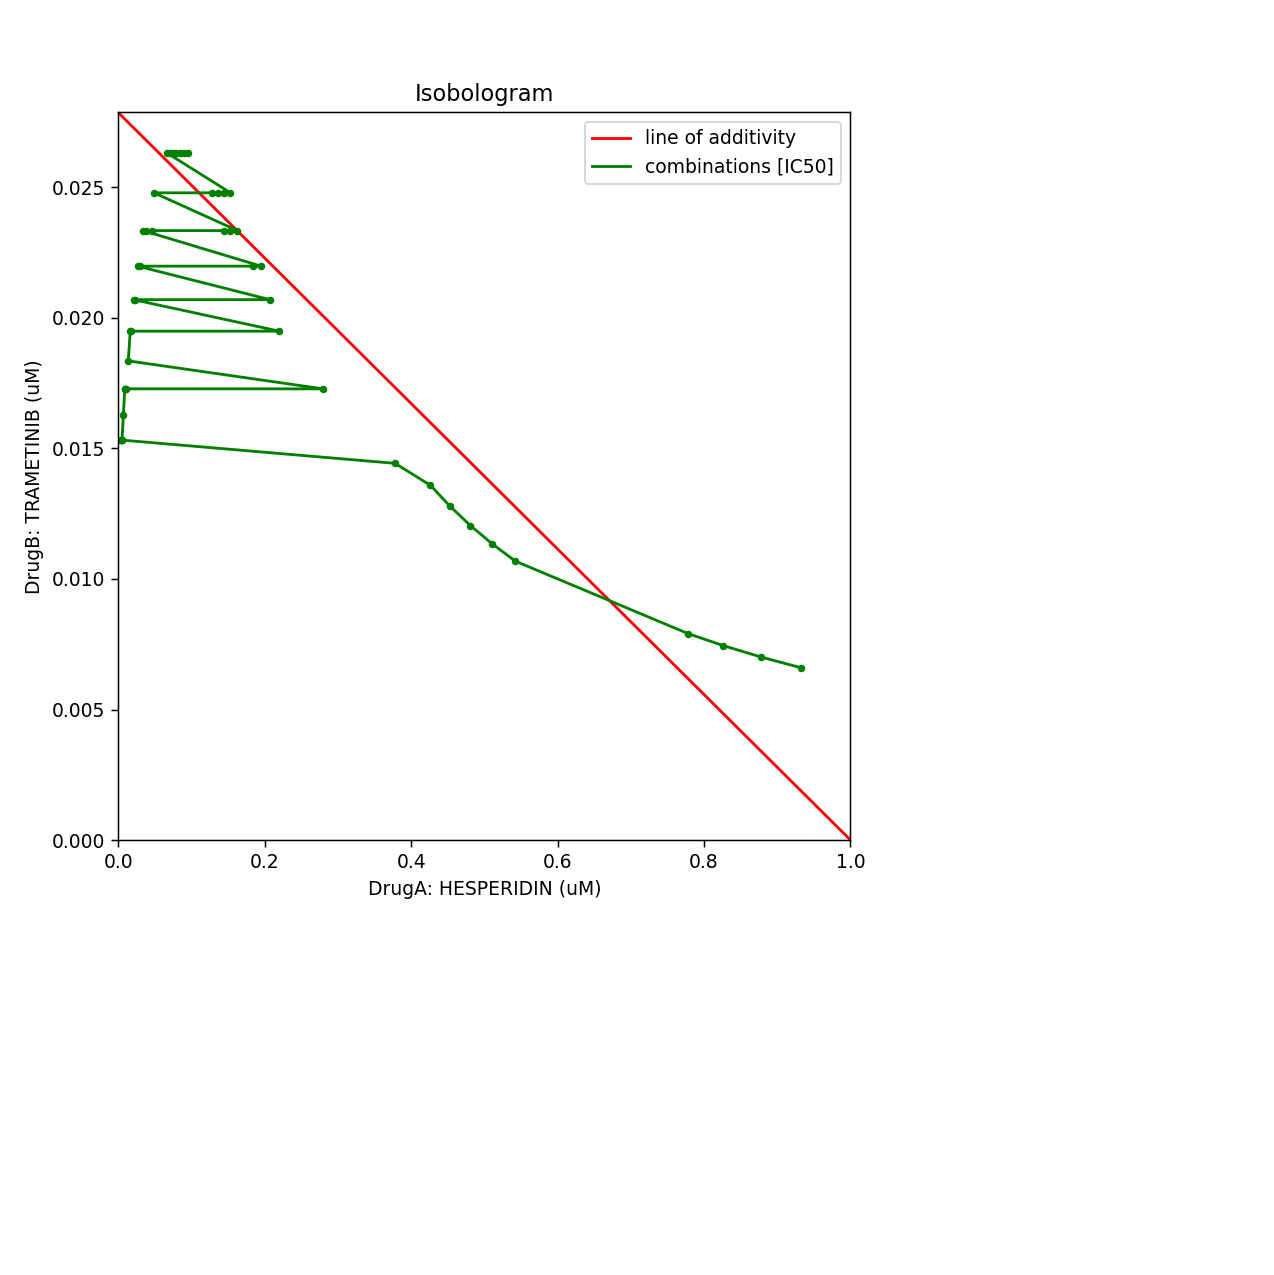

In [14]:
print(f'drugA ({drugA}) IC{IC_value}: {10**ICxxA} (uM) [log={ICxxA}]')
print(f'drugB ({drugB}) IC{IC_value}: {10**ICxxB} (uM) [log={ICxxB}]')

#comb = pd.DataFrame(ICs).drop_duplicates()

print(comb.head())

plt.figure(figsize=(7,7)) 

x = [10**ICxxA,0]
y = [0, 10**ICxxB]


plt.plot(x,y, 'r', label='line of additivity')
plt.plot(10**comb.x.values, 10**comb.y.values, 'g-', label=f'combinations [IC{int(IC_value*100)}]')
plt.plot(10**comb.x.values, 10**comb.y.values, 'g.')

plt.xlim(x[::-1])
plt.ylim(y)
plt.xlabel(f'DrugA: {drugA} (uM)')
plt.ylabel(f'DrugB: {drugB} (uM)')
plt.legend()
plt.title('Isobologram')

plt.show() 

![](../docs/iso.PNG)

range conc A: (0.0034714503763459744, 0.9319955195977768)
range conc B: (0.006602698054976901, 0.02632799847911802)
minimum CI value [0.55] found at: HESPERIDIN=[0.00347145], TRAMETINIB=[0.01532367]]
This combination is synergistic between: HESPERIDIN:[0.00347-0.54245], TRAMETINIB:[0.01068-0.02479]


<IPython.core.display.Javascript object>


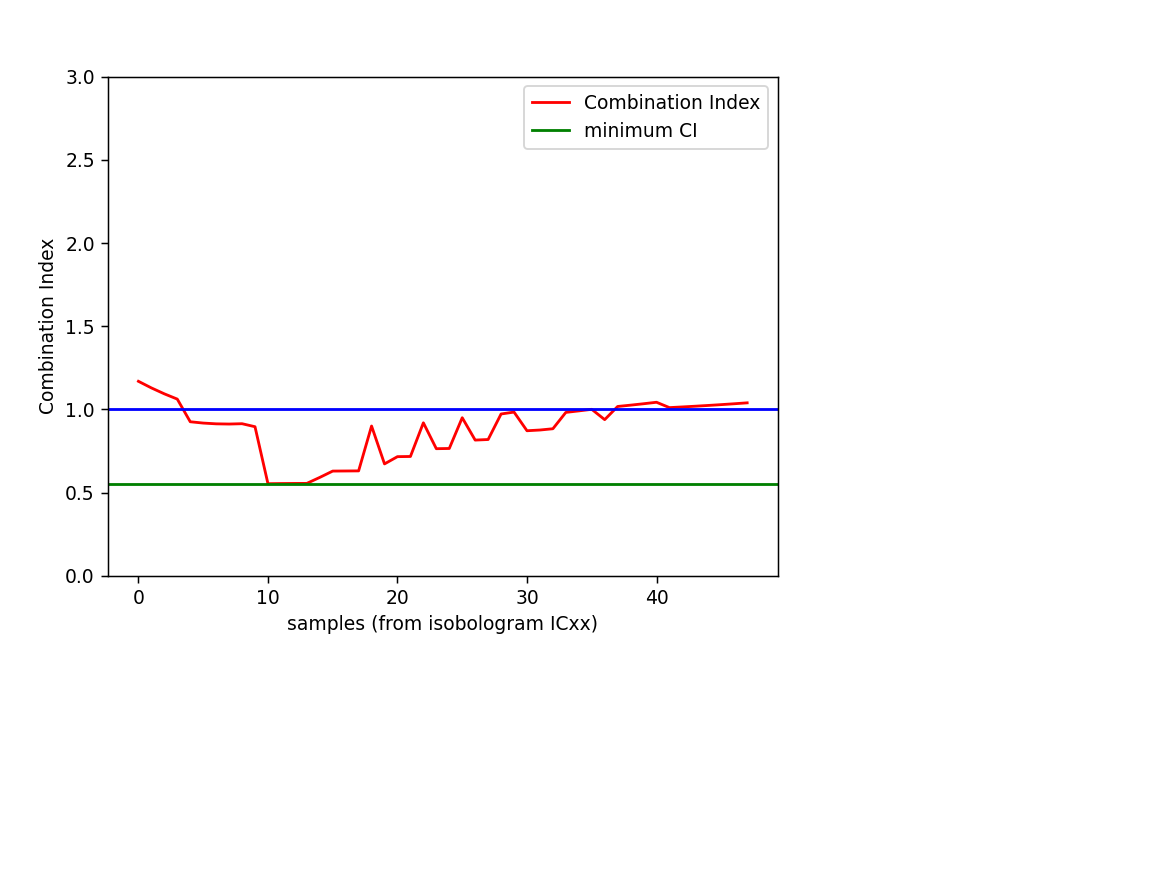

In [15]:
C_a = 10**np.array( comb.x.values ) #ICs['x'] )
print('range conc A:', (C_a.min(), C_a.max()))
C_b = 10**np.array( comb.y.values) #ICs['y'] )
print('range conc B:', (C_b.min(), C_b.max()))


CI = C_a/(10**ICxxA) + C_b/(10**ICxxB)

idx = np.where(CI == min(CI))
Ca_min = C_a[idx]
Cb_min = C_b[idx]

print(f'minimum CI value [{min(CI):.2f}] found at: {drugA}={Ca_min}, {drugB}={Cb_min}]')

idx2 = np.where(CI < 1)
Ca_range = C_a[idx2]
Cb_range = C_b[idx2]

synergy_concentrations_CI = pd.DataFrame({'DrugA_conc': Ca_range, 'DrugB_conc':Cb_range})
synergy_concentrations_CI.to_csv('./CI_synergy_range.csv', index=False)

print(f'This combination is synergistic between: {drugA}:[{min(Ca_range):.5f}-{max(Ca_range):.5f}], {drugB}:[{min(Cb_range):.5f}-{max(Cb_range):.5f}]')

plt.figure()
plt.plot(CI, 'r', label='Combination Index')
plt.axhline(min(CI), c='g', label='minimum CI')
plt.axhline(1, c='b')
plt.xlabel('samples (from isobologram ICxx)')
plt.ylabel('Combination Index')
plt.ylim(0,3)
plt.legend()
plt.show()